---
title: "Can flow-based models to find equilibrium distributions? (Draft)"
author: Austin Hoover
date: 2025-03-23
bibliography: references.bib
csl: ./aps.csl
categories:
  - nonlinear
  - generative models
toc: false
---

The phase space density $f(\mathbf{x}, \dot{\mathbf{x}}, t)$ of a collisionless plasma obeys the Vlasov equation:
$$
    \frac{df}{dt} 
    =
    \frac{\partial{f}}{\partial{t}} + 
    \dot{\mathbf{x} } \cdot \frac{\partial{f}}{\partial{     \mathbf{x}}} + 
    \frac{q}{m} \left( \mathbf{E} + \mathbf{v} \times \mathbf{B} \right) \cdot \frac{\partial{f}}{\partial{\dot{\mathbf{x}}}} 
    = 0,
$$ {#eq-vlasov}

where $q$ is the particle charge, $m$ is the particle mass, $\mathbf{E}$ is the electric field, and $\mathbf{B}$ is the magnetic field. $\mathbf{E}$ and $\mathbf{B}$ account for both external/applied and internal/self-generated fields. Assume that self-generated magnetic fields are negligible and that applied fields are entirely magnetic. Then $\mathbf{B}(\mathbf{x}, t)$ is given and $\mathbf{E}(\mathbf{x}, t)$ is determined by the Poisson equation:

$$
\frac{\partial}{\partial \mathbf{x}} \mathbf{E}(\mathbf{x}, t) =  \int f(\mathbf{x}, 
\dot{\mathbf{x}}, t) d\dot{\mathbf{x}}
$$ {#eq-poisson}

Equilibrium solutions to this set of equations are functions of invariants $\{c_i\}$, since
$$
\frac{d}{dt} f(\{c_i\}) = \sum_i \frac{df}{dc_i} \frac{dc_i}{dt} = 0.
$$ {#eq-invariants}
To find an equilibrium distribution, we must build a distribution function out of single-particle invariants, compute the electric field from @eq-poisson, and verify that the fields preserve the invariants.

For time-dependent external fields, the Kapchinskij-Vladimirskij (KV) distribution is the only known equilibrium distribution. The KV distribution is a function of linear-field invariants, and it generates a linear electric field, closing the feedback loop. But the structure of the KV distribution (a 4D ellipsoid) makes it unstable with respect to small perturbations in periodic focusing systems. Certain external field configurations can drive filamentation of the phase space which does not occur in realistic beams. To probe intensity limits, it makes more sense to launch an equilibrium distribution that is a smooth function of invariants rather than a delta function. Unfortunately, a nonuniform charge density generates nonlinear electric forces, and finding invariants in nonlinear systems is *much* more challenging than in linear systems. There is no proof of the existence or nonexistence of equilibrium distributions in such systems.

Lund @Lund_2009 suggested a method to construct smooth 4D "pseudoequilibrium" distributions which are not strictly equilibrium distributions but exhibit much less filamentation than the KV distribution. The method works by constructing a smooth approximation of a time-dependent focusing channel, for which exact equilibrium distributions can be constructed, and then transforming back to rms equivalency in the original channel. This worked very well. Below is a screenshot from the paper showing the profile evolutions for two beams with the same rms moments but different density profiles. On the left is a Waterbag distribution (uniformly filled 4D ellipsoid) and on the right is the pseudoequilibrium distribution.

::: {layout-ncol=2 align=left}
<img src="images/fig_lund_prof_01.png" width="300px">

<img src="images/fig_lund_prof_02.png" width="300px">
:::

Partly motivated by [this talk](https://conference.sns.gov/event/335/contributions/526/attachments/891/8197/Antonsen_Knoxville_V2.pdf), I've started to think that [normalizing flows](https://jmlr.org/papers/volume22/19-1028/19-1028.pdf) could be used to find 6D pseudoequilibrium distributions in coupled or nonlinear lattices. The idea would be to train a model to generate a distribution that is invariant after one pass though the accelerator lattice. Flows are typically trained on samples $\{\mathbf{x}_i \} \sim f(\mathbf{x})$ from an unknown distribution $f(\mathbf{x})$. The training procedure minimizes a Monte Carlo estimate of the KL divergence between the unknown $f(\mathbf{x})$ and the model distribution $f_\theta(\mathbf{x})$, where $\theta$ is a vector of parameters:

$$
D[f(\mathbf{x}), f_\theta(\mathbf{x})] = \int f(\mathbf{x}) ( \log f(\mathbf{x}) - \log f_\theta(\mathbf{x}) ) d\mathbf{x}.
$$ {#eq-kl}

Since the first term doesn't depend on $\theta$, we can drop it and just minimize the following loss function:

$$
L(\theta) = - \int f(\mathbf{x}) \log f_\theta(\mathbf{x})  d\mathbf{x}.
$$ {#eq-loss-long}

Finally, although we don't have access to $f(\mathbf{x})$, we do have access to samples $\{\mathbf{x}_i\} \sim f(\mathbf{x})$. Thus we can estimate the integral by the Monte Carlo approximation

$$
L(\theta) = - \frac{1}{N} \sum_{i=1}^N \log f_\theta(\mathbf{x}_i).
$$ {#eq-loss}

The loss in @eq-loss is often called the *negative log likelihood* or *NLL*, and this procedure is called *maximum likelihood training*.

Let's define the phase space coordinates in the initial distribution as $\mathbf{x}(0)$ and the transformed coordinates as $\mathbf{x}(t)$. Our task is to minimize the divergence between initial distribution $f_{t_0}(\mathbf{x})$ and the final distribution $f_{t_1}(\mathbf{x})$, where $t_1 - t_0$ is the period length. Given a normalizing flow, we can generate samples from $f_{t0}$ by sampling from a normal distribution and sending the samples through the flow. And we can generate samples from $f_{t_1}$ by integrating the equations of motion. Then we could try to minimize the KL divergence between the two distributions using @eq-loss, where the samples are now from $f_{t_1}$. The difference is that the samples now depend on the model parameters $\theta$.

I'll label the coordinates after one lattice period as $\tilde{\mathbf{x}}$, so the loss function becomes:
$$
L(\theta) = - \frac{1}{N} \sum_{i=1}^N \log f_\theta ( \tilde{\mathbf{x}}_i ).
$$ {#eq-loss-new}

To minimize @eq-loss-new with respect to $\theta$, the forward operator $\mathcal{M}$ must be differentiable. Several differentiable accelerator elements have been released as part of the Cheetah code @Kaiser_2024. I also saw that a 3D space charge solver was [added to Cheetah](https://github.com/desy-ml/cheetah/pull/142). It looks like the solver uses the FFT Greens function approach, but I haven't looked at the details.

This post is a quick test to see if the optimization scheme will work in 2D, not including space charge. I'll use a nonlinear map which should admit stationary solutions but does not admit simple single-particle invariants as in linear systems @Zolkin_2024. Each transformation will consist of a rotation in phase space followed by a nonlinear kick.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import zuko

In [2]:
#| echo: false
plt.rcParams["axes.linewidth"] = 1.25
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["figure.dpi"] = 100
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

In [3]:
class Transform(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError
        

class ComposedTransform(Transform):
    def __init__(self, *transforms) -> None:
        super().__init__()
        self.transforms = torch.nn.Sequential(*transforms)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_out = torch.clone(x)
        for transform in self.transforms:
            x_out = transform(x_out)
        return x_out
        

class Rotation(Transform):
    def __init__(self, angle: float, **kwargs) -> None:
        super().__init__(**kwargs)
        self.matrix = torch.zeros((2, 2))
        self.matrix[0, 0] = +math.cos(angle)
        self.matrix[1, 1] = +math.cos(angle)
        self.matrix[0, 1] = +math.sin(angle)
        self.matrix[1, 0] = -math.sin(angle)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.matmul(x, self.matrix.T)
        

class Drift(Transform):
    def __init__(self, length: float, **kwargs) -> None:
        super().__init__(**kwargs)
        self.length = length
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_out = torch.clone(x)
        x_out[:, 0] += x_out[:, 1] * length
        return x_out


class NonlinearKick(Transform):
    # https://arxiv.org/abs/2405.05657
    def __init__(self, phi: float, A: float, E: float, T: float, **kwargs) -> None:
        super().__init__(**kwargs)
        self.phi = torch.tensor(phi)
        self.A = A
        self.E = E
        self.T = T

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        E = self.E
        A = self.A
        T = self.T
        phi = self.phi
        
        _x  = x[:, 0]
        _px = x[:, 1]
        _y  = _x * 0.0
        _py = _px * 0.0
        
        r = torch.abs(_x)
        t = torch.arctan2(_y, _x)

        dr = -(1.0 / (torch.sin(phi))) * ((E * r) / (A * r**2 + T)) - ((2.0 * r) / (torch.tan(phi)))

        x_out = x.clone()
        x_out[:, 1] += dr * torch.cos(t)
        return x_out

In [4]:
phi = 2.0 * math.pi * 0.18  # phase advance

transforms = []
for _ in range(20):
    transforms.append(Rotation(phi))
    transforms.append(NonlinearKick(phi=phi, A=1.0, E=0.9, T=1.0))
transform = ComposedTransform(*transforms)

[Zuko](https://github.com/probabilists/zuko) provides nice implementations of standard flow architectures. I'll use the Neural Spline Flow (NSF) architecture here. This model uses autoregressive layers, so it's $D$ times as fast one direction (density evaluation) than the other direction (sampling) for phase space dimension $D$. We'll have to do both in this training loop, so coupling layers would be better in a future implementation.

In [5]:
ndim = 2
flow = zuko.flows.NSF(features=ndim, transforms=3, hidden_features=[64] * 2)

Let's start the model at a Gaussian distribution. The initial model parameters are initialized randomly. To move toward a Gaussian distribution, we can train the flow by reverse KL:

In [6]:
optimizer = torch.optim.Adam(flow.parameters(), lr=0.01)

prior_loc = torch.zeros(ndim)
prior_cov = torch.eye(ndim)
prior = torch.distributions.MultivariateNormal(prior_loc, prior_cov)

for iteration in range(20):
    x, log_prob = flow().rsample_and_log_prob((1_000,))
    loss = torch.mean(log_prob) - torch.mean(prior.log_prob(x))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(iteration, loss)

0 tensor(0.2569, grad_fn=<SubBackward0>)
1 tensor(4.1617, grad_fn=<SubBackward0>)
2 tensor(0.4406, grad_fn=<SubBackward0>)
3 tensor(0.1966, grad_fn=<SubBackward0>)
4 tensor(0.4468, grad_fn=<SubBackward0>)
5 tensor(0.5276, grad_fn=<SubBackward0>)
6 tensor(0.4098, grad_fn=<SubBackward0>)
7 tensor(0.3596, grad_fn=<SubBackward0>)
8 tensor(0.2974, grad_fn=<SubBackward0>)
9 tensor(0.2163, grad_fn=<SubBackward0>)
10 tensor(0.1174, grad_fn=<SubBackward0>)
11 tensor(0.0549, grad_fn=<SubBackward0>)
12 tensor(0.0858, grad_fn=<SubBackward0>)
13 tensor(0.1349, grad_fn=<SubBackward0>)
14 tensor(0.0939, grad_fn=<SubBackward0>)
15 tensor(0.0565, grad_fn=<SubBackward0>)
16 tensor(0.0508, grad_fn=<SubBackward0>)
17 tensor(0.0540, grad_fn=<SubBackward0>)
18 tensor(0.0242, grad_fn=<SubBackward0>)
19 tensor(0.0383, grad_fn=<SubBackward0>)


Here's the initial Gaussian distribution propagated through the accelerator model:

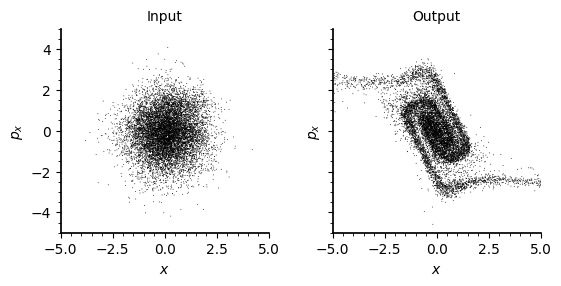

In [7]:
#| code-fold: true
#| fig-align: center
def plot_flow(flow, transform, nsamp=1_000, **kws):
    x0 = flow().sample((nsamp,))
    x1 = transform(x0.clone())
    
    x0 = x0.detach().numpy()
    x1 = x1.detach().numpy()

    fig, axs = plt.subplots(
        ncols=2, figsize=(5.5, 2.75), sharex=True, sharey=True, gridspec_kw=dict(wspace=0.1),
    )
    for ax, x in zip(axs, [x0, x1]):
        ax.scatter(x[:, 0], x[:, 1], **kws)
        ax.set_xlim(-5.0, 5.0)
        ax.set_ylim(-5.0, 5.0)
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$p_x$")       
    for ax, title in zip(axs, ["Input", "Output"]):
        ax.set_title(title, fontsize="medium")    
    return fig, axs


with torch.no_grad():
    fig, axs = plot_flow(flow, transform, nsamp=10_000, s=0.4, c="black", ec="none")

I'll train the flow using the ADAM optimizer and batches of 1000 particles. Without space charge, there should be an infinite number of periodic distributions. The model can also simply collapse to a delta function, with all particles starting and ending at the origin. To encourage a unique solution, I'll add an entropy penalty to pull the distribution toward a simple Gaussian.

In [8]:
# Find stationary distribution
optimizer = torch.optim.Adam(flow.parameters(), lr=0.01)
for iteration in range(51):
    x, log_prob = flow().rsample_and_log_prob((1_000,))  # model will have unnorm_matrix
    x_out = transform(x)

    # KL divergence between input and output distributions
    loss = torch.mean(-flow().log_prob(x_out))
    
    # KL divergence between input and Gaussian distribution
    loss = loss + 1.0 * torch.mean(log_prob)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if iteration % 25 == 0:
        print(f"iter={iteration} loss={loss}")

iter=0 loss=0.8728091716766357
iter=25 loss=0.02266407012939453
iter=50 loss=0.006170749664306641


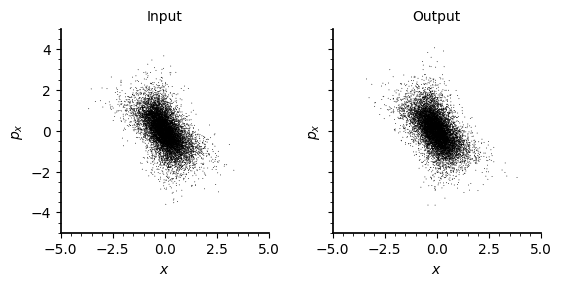

In [9]:
#| code-fold: true
#| fig-align: center
with torch.no_grad():
    fig, axs = plot_flow(flow, transform, nsamp=10_000, s=0.4, c="black", ec="none")
    plt.show()

The model appears to be working. The next step will be to explore the Cheetah space charge module and build a test case for this algorithm.  